In [ ]:
from typing import List, Tuple
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import seaborn as sns
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import pymorphy2
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AutoTokenizer, AutoModel
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
import string
tqdm.pandas()

In [2]:
device = 'cuda:0'

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# load initial data

In [3]:
df = pd.read_csv('data_description.csv')
df = df[:10000]
df = df[df['description'].notna()]

# deduplication

In [4]:
def average_pool(last_hidden_states: torch.Tensor,
                 attention_mask: torch.Tensor) -> torch.Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]


def get_similarities(df: pd.DataFrame, embs: np.array) -> pd.DataFrame:
    
    csim = cosine_similarity(embs)
    
    bad_idx = []

    for j, line in enumerate(csim):
        idx = np.where(line > 0.99)[0]
        bad_idx += [idx[idx != j]]
        
    bad_idx = np.concatenate(bad_idx)
    
    df = df.iloc[~df.index.isin(bad_idx)]
    
    return df

tokenizer = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-large')
model = AutoModel.from_pretrained('intfloat/multilingual-e5-large')

model.to(device);

In [5]:
sents = df['description'].tolist()
sents = [s if s is not None else '' for s in sents]

In [6]:
bsize = 16
num_batches = (len(sents) // bsize) + 1 if len(sents) % bsize != 0 else len(sents) // bsize

emb_list = []

for i in tqdm(range(num_batches)):
    slc = sents[i*bsize:(i+1)*bsize]
    slc = ['query: ' + sent for sent in slc]
    
    encoded_input = tokenizer(
        slc, padding=True, truncation=True, 
        max_length=512,
        return_tensors='pt'
    )
    encoded_input = {k: encoded_input[k].to(device) for k in encoded_input.keys()}
    
    with torch.no_grad():
        model_output = model(**encoded_input)
        
    emb_list += [
        average_pool(model_output.last_hidden_state, encoded_input['attention_mask']).cpu().numpy()
    ]

100%|██████████| 536/536 [00:43<00:00, 12.28it/s]


In [7]:
all_embs = np.concatenate(emb_list)
all_embs.shape

(8576, 1024)

In [8]:
df_sem = get_similarities(df, all_embs)
print(f'{100 * (df.shape[0] - df_sem.shape[0]) / df.shape[0]:.2f}% - deduplication')

60.62% - deduplication


# perplexity distribution

In [9]:
model_name_or_path = "ai-forever/rugpt3large_based_on_gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name_or_path)
model = GPT2LMHeadModel.from_pretrained(model_name_or_path).to(device)

In [10]:
sents = df['description'].tolist()
sents = [s if s is not None else '' for s in sents]

In [11]:
class TextDataset(Dataset):
    def __init__(self, texts, tokenizer):
        self.texts = texts
        self.tokenizer = tokenizer
        
    def __getitem__(self, idx):
        txt = self.tokenizer.bos_token + self.texts[idx] + self.tokenizer.eos_token
        
        tokenized = self.tokenizer(
            txt, padding=True, truncation=True, 
            max_length=512, return_tensors='pt'
        )
        
        tokenized_inp = tokenized['input_ids'][:, :-1].squeeze(0)
        att_mask = tokenized['attention_mask'][:, :-1].squeeze(0)
        
        tokenized_trg = tokenized['input_ids'][:, 1:].squeeze(0)
        
        return tokenized_inp, att_mask, tokenized_trg
    
    def __len__(self):
        return len(self.texts)
    

def collate_fn(data: List[Tuple[torch.Tensor, torch.Tensor, torch.Tensor]]):
    tokenized_inp, att_mask, tokenized_trg = zip(*data)
    
    tokenized_inp = pad_sequence(list(tokenized_inp), batch_first=True)
    att_mask = pad_sequence(list(att_mask), batch_first=True)
    tokenized_trg = pad_sequence(list(tokenized_trg), batch_first=True)

    return tokenized_inp, att_mask, tokenized_trg

In [12]:
dset = TextDataset(sents, tokenizer)
dloader = DataLoader(dset, batch_size=4, collate_fn=collate_fn)

In [13]:
bsize = 4
num_batches = (
    (len(sents) // bsize) + 1 
    if len(sents) % bsize != 0 
    else len(sents) // bsize
)

ls = torch.nn.CrossEntropyLoss(ignore_index=0, reduction='none')

loss_list = []

for encoded_input in tqdm(dloader, total=len(dloader)):
    encoded_input = [ei.to(device) for ei in encoded_input]
    
    with torch.no_grad():
        model_output = model(input_ids=encoded_input[0], attention_mask=encoded_input[1])
        
    batch_loss = ls(model_output.logits.permute(0, 2, 1), encoded_input[2])
    batch_loss = batch_loss.sum(axis=-1) / encoded_input[1].sum(axis=-1)
    
    loss_list += [batch_loss.cpu().numpy()]

100%|██████████| 2144/2144 [01:41<00:00, 21.20it/s]


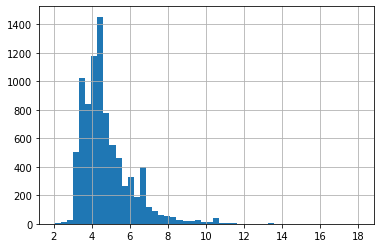

In [14]:
df['ce_loss'] = np.concatenate(loss_list)
df['ce_loss'].hist(bins=50);

In [15]:
df.loc[
    df['ce_loss'] > df['ce_loss'].mean() + 3 * df['ce_loss'].std()
].sort_values('ce_loss', ascending=False)

,description,ce_loss
8622,Было,18.036140
3940,Жизнь,17.965612
3966,#кино,14.252734
427,#кино,14.252734
5248,#спорт,14.003589
7755,если так,13.553810
3180,фильмы,13.483139
4539,фильмы,13.483132
5310,Мы?,13.374962
3642,Walls,13.272603


# Basic statistics

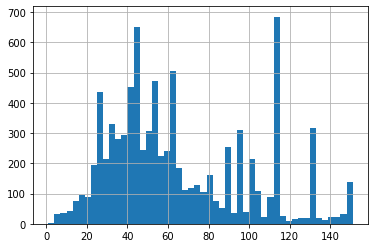

In [16]:
df['text_len'] = df['description'].str.len()
df_stats = df['text_len'].describe()

df['text_len'].hist(bins=50);

In [20]:
tokenizer = GPT2Tokenizer.from_pretrained('ai-forever/rugpt3small_based_on_gpt2')

In [21]:
df['tokenized'] = df.apply(lambda x: tokenizer.encode(x['description']), axis=1)

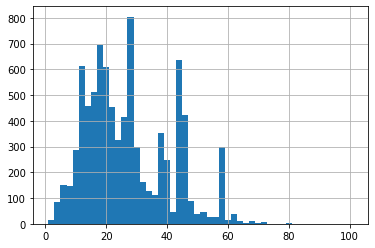

In [22]:
df['num_tokens'] = df['tokenized'].str.len()
df['num_tokens'].hist(bins=50);

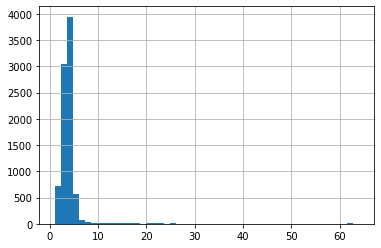

In [23]:
df['num_words'] = df['description'].str.split().str.len()
df['tokens_per_word'] = df['num_tokens'] / df['num_words']

df['tokens_per_word'].hist(bins=50);

### Mean word lengths

In [24]:
df['mean_word_len'] = df['description'].str.split().apply(
    lambda x: np.mean([len(w) for w in x])
)

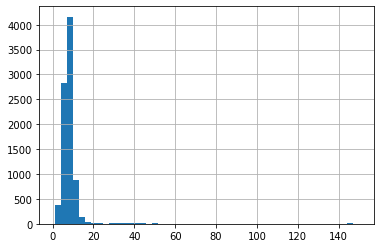

In [25]:
df['mean_word_len'].hist(bins=50);

### Punctuation count

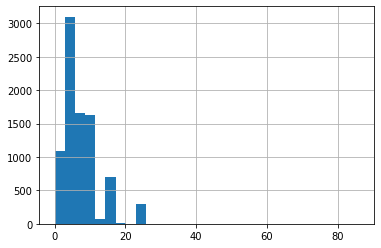

In [26]:
df['punc_count'] = df['description'].apply(
    lambda x: [w for w in x if w in string.punctuation]
).str.len()
df['punc_count'].hist(bins=30);

### Word count statistics

In [27]:
from pymystem3 import Mystem

mystem = Mystem()

def preprocess_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [
        token for token in tokens if token not in stop_words
        and token != " " 
        and token.strip() not in string.punctuation
    ]
    
    text = " ".join(tokens)
    
    return text

In [50]:
df['preproc_text'] = df['description'].apply(preprocess_text).str.split()

In [51]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:30]


def plot_top_ngrams_barchart(text: str, cls_name: str, n: int=2) -> None:
    top_n_bigrams = get_top_ngram(text, n)[:30]
    x, y = map(list, zip(*top_n_bigrams))
    sns.barplot(x=y, y=x, color="darkgreen")
    plt.title(f"{cls_name}\n ngrams(n={n})")
    plt.show()

In [52]:
plt.rcParams.update({'font.size': 14})

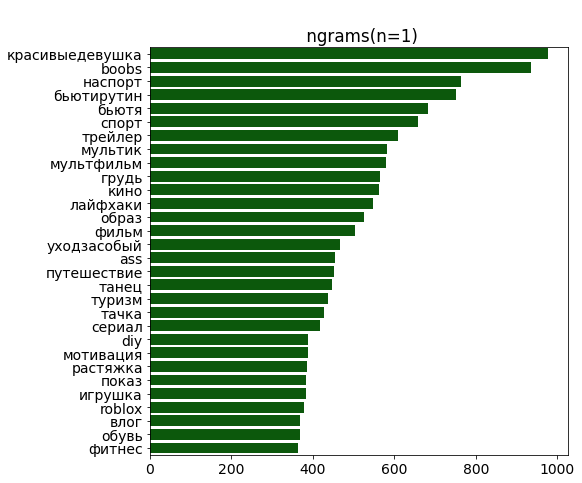

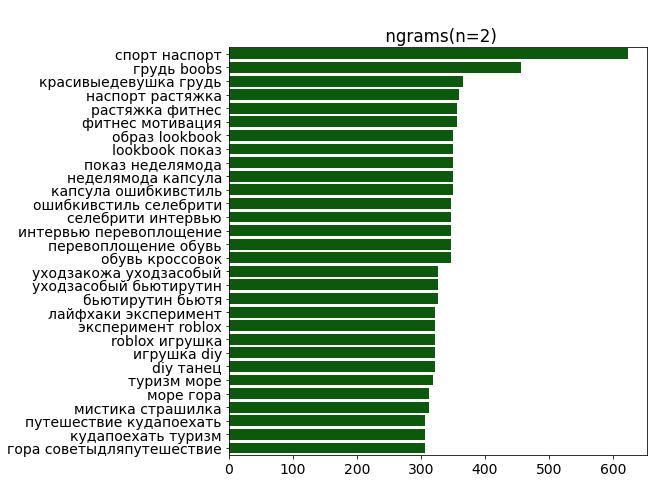

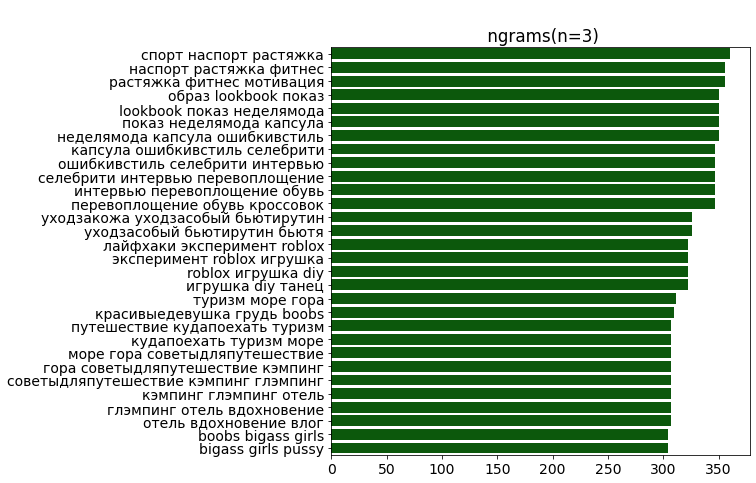

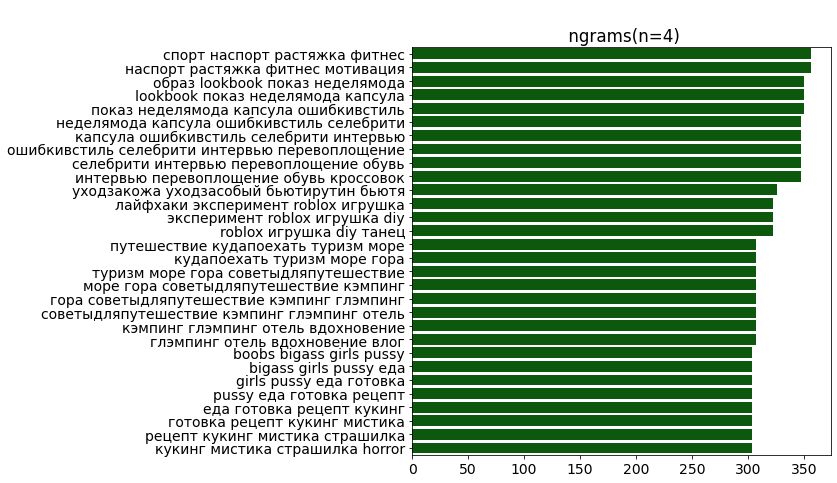

In [53]:
for n_gram in range(1, 5):
    plt.figure(figsize=(7.5, 7.5))
    plot_top_ngrams_barchart(df['preproc_text'].str.join(' ').values, '', n=n_gram)